# Machine learning project

## Preprocess the dataset

### Import libraries and datasets

**Description**: Import necessary libraries and load the dataset for preprocessing. Combine multiple files into a single dataset for unified analysis.
- **Goal**: Prepare data for further cleaning and transformation.

In [45]:
# Import all librarides needed.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer  # This enables the experimental feature
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import os

# Random forest
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
# XGBoost
from xgboost import XGBClassifier

# Hypertuning for RandomForest
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
import os

# ML Flow
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from sklearn.metrics import precision_score, recall_score

import shap

In [3]:
# Create a dictionary with the path of each Dataset
path = 'Dataset/'
paths = {
    'Monday': path + 'Monday-WorkingHours.pcap_ISCX.csv',
    'Tuesday': path + 'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday': path + 'Wednesday-workingHours.pcap_ISCX.csv',
    'Thursday': path + 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Friday-DDOS': path + 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday-PortScan': path + 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'

}

# Load each dataset
dataframes = []
for day, path in paths.items():
    df = pd.read_csv(path)
    df['Day'] = day
    dataframes.append(df)

# Combine all datasets into one DataFrame
all_data = pd.concat(dataframes, ignore_index=True)

# Display dataset info
print("Combined Dataset Info:")
print(all_data.info())

Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351108 entries, 0 to 2351107
Data columns (total 80 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18 

### Clean and preprocess the dataset

If you don't want to wait for the cleaning, you can execute the next part with the `cleaned_dataset.csv` file.
**Description**: Replace infinite values, drop rows with excessive missing data, and handle outliers. Numerical data is imputed using an iterative approach.
- **Key Steps**:
  - Imputation using `IterativeImputer`.
  - Encoding categorical data using `LabelEncoder`.
  - Capping extreme values for numerical stability.
- **Results**:
  - Dataset cleaned with no missing values.
  - Rows retained: 2351108. 

In [4]:
# Replace inf and -inf with NaN
all_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Calculate the threshold for keeping rows (50% of total columns)
threshold = len(all_data.columns) / 2

# Drop rows with more than 50% missing values
data_cleaned = all_data.dropna(thresh=threshold)

print("Number of rows before cleaning:", len(all_data))
print("Number of rows after cleaning:", len(data_cleaned))

# Separate numerical and categorical columns
numerical_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data_cleaned.select_dtypes(include=['object', 'category']).columns

# Cap extremely large values only for numerical columns
max_threshold = 1e6
data_cleaned[numerical_cols] = data_cleaned[numerical_cols].clip(upper=max_threshold)

# Impute numerical columns
imputer = IterativeImputer(random_state=42)
data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])

# Encode categorical columns
encoder = LabelEncoder()
for col in categorical_cols:
    data_cleaned[col] = encoder.fit_transform(data_cleaned[col].astype(str))

# Verify imputation
print("Missing values after imputation:")
print(data_cleaned.isnull().sum())

Number of rows before cleaning: 2351108
Number of rows after cleaning: 2351108
Missing values after imputation:
 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Day                            0
Length: 80, dtype: int64


```IterativeImputer```:
- This is a scikit-learn imputation class that fills missing values in numerical data.
- It uses a multivariate approach: missing values are predicted based on other columns using a regression model.
- It works iteratively: each feature with missing values is modeled as a function of other features, and the process is repeated multiple times for refinement.
```.fit_transform()```:
- fit(): Learns the patterns and relationships in the data to create a model for imputing missing values.
- transform(): Applies the learned imputation model to fill the missing values.



In [5]:
# Total number of missing values across all columns
total_missing = data_cleaned.isnull().sum().sum()

print(f"Total number of missing values in the Dataset: {total_missing}")
# Save the cleaned Dataset to a CSV file for save time after
data_cleaned.to_csv('cleaned_dataset.csv', index=False)

# Copy the cleaned Dataset to use it everywhere
all_data = data_cleaned

Total number of missing values in the Dataset: 0


### Exploring the data
If you want to use the csv of the data already clean, just execute the cell below

**Description**: Summarize dataset features to understand distributions, ranges, and potential anomalies.
- **Key Visualizations**:
  - Histograms for key features.
  - Class distribution for imbalance detection.


In [6]:
all_data = pd.read_csv('Dataset/cleaned_dataset.csv')

In [7]:
# Summary of the Dataset
print("Dataset Summary:")
print(all_data.describe())

Dataset Summary:
        Destination Port   Flow Duration   Total Fwd Packets  \
count       2.351108e+06    2.351108e+06        2.351108e+06   
mean        8.163563e+03    3.337319e+05        9.382722e+00   
std         1.849374e+04    4.445273e+05        7.603036e+02   
min         0.000000e+00   -1.300000e+01        1.000000e+00   
25%         5.300000e+01    1.630000e+02        1.000000e+00   
50%         8.000000e+01    3.574800e+04        2.000000e+00   
75%         4.430000e+02    1.000000e+06        5.000000e+00   
max         6.553500e+04    1.000000e+06        2.197590e+05   

        Total Backward Packets  Total Length of Fwd Packets  \
count             2.351108e+06                 2.351108e+06   
mean              1.041678e+01                 5.409034e+02   
std               1.009094e+03                 5.117577e+03   
min               0.000000e+00                 0.000000e+00   
25%               1.000000e+00                 1.200000e+01   
50%               2.000000e+

In the cell below, we print and plot the number of values we have for each label. It allows us to detect the label that may cause unbalanced data.

Label
0     1795464
3      231073
8      158930
1      128027
2       10293
6        7938
9        5897
5        5796
4        5499
10       1507
12        652
11         21
7          11
Name: count, dtype: int64


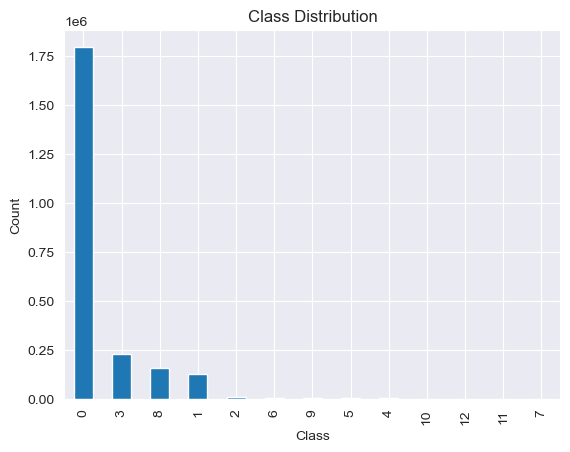

In [8]:
# Strip leading and trailing whitespace from column names
all_data.columns = all_data.columns.str.strip()

# Now access the 'Label' column
print(all_data['Label'].value_counts())

all_data['Label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Features such as Flow Duration and Total Fwd Packets show significant variability, indicating potential outliers and scaling needs.

                              min        max
Destination Port              0.0    65535.0
Flow Duration               -13.0  1000000.0
Total Fwd Packets             1.0   219759.0
Total Backward Packets        0.0   291922.0
Total Length of Fwd Packets   0.0  1000000.0
...                           ...        ...
Idle Std                      0.0  1000000.0
Idle Max                      0.0  1000000.0
Idle Min                      0.0  1000000.0
Label                         0.0       12.0
Day                           0.0        5.0

[80 rows x 2 columns]


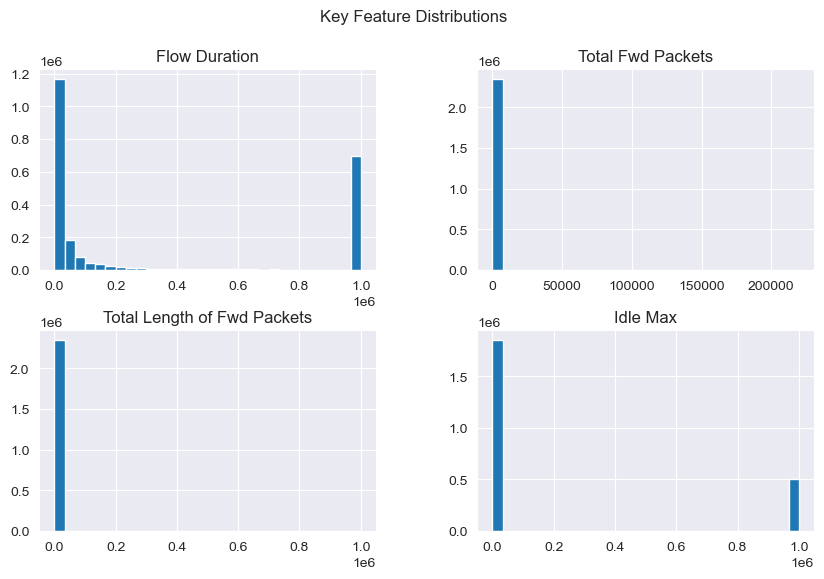

In [9]:
# Select numerical columns
numerical_columns = all_data.select_dtypes(include=['number']).columns

# Verify the new range
print(all_data[numerical_columns].agg(['min', 'max']).T)

# List of key features
key_features = ['Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Idle Max']

# Plot histograms for key features
all_data[key_features].hist(figsize=(10, 6), bins=30)
plt.suptitle('Key Feature Distributions')
plt.show()

### Correlation Heatmap

**Description**: Identify top features most correlated with the target label using a heatmap.
- **Purpose**: Highlight features critical for model performance.

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


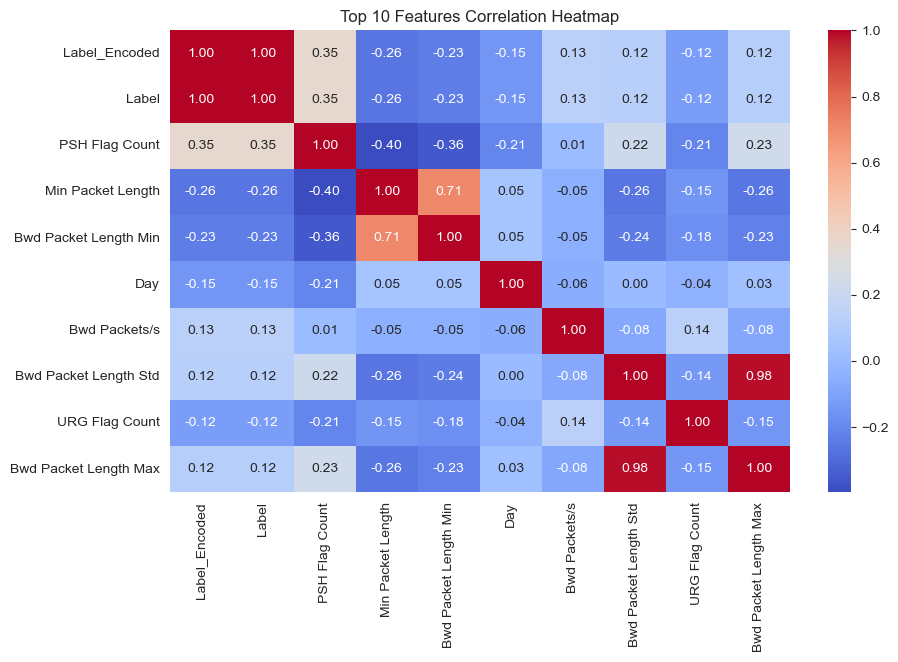

In [10]:
# Encode the 'Label' column
le = LabelEncoder()
all_data['Label_Encoded'] = le.fit_transform(all_data['Label'])
numerical_data = all_data.select_dtypes(include=['number'])

# Recalculate correlations with the target variable (Label_Encoded)
target_corr = numerical_data.corrwith(all_data['Label_Encoded']).abs().sort_values(ascending=False)

# Select top 10 most correlated features
top_features = target_corr.head(10).index

plt.figure(figsize=(10, 6))
sns.heatmap(numerical_data[top_features].corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Top 10 Features Correlation Heatmap')
plt.show()

### Box Plot

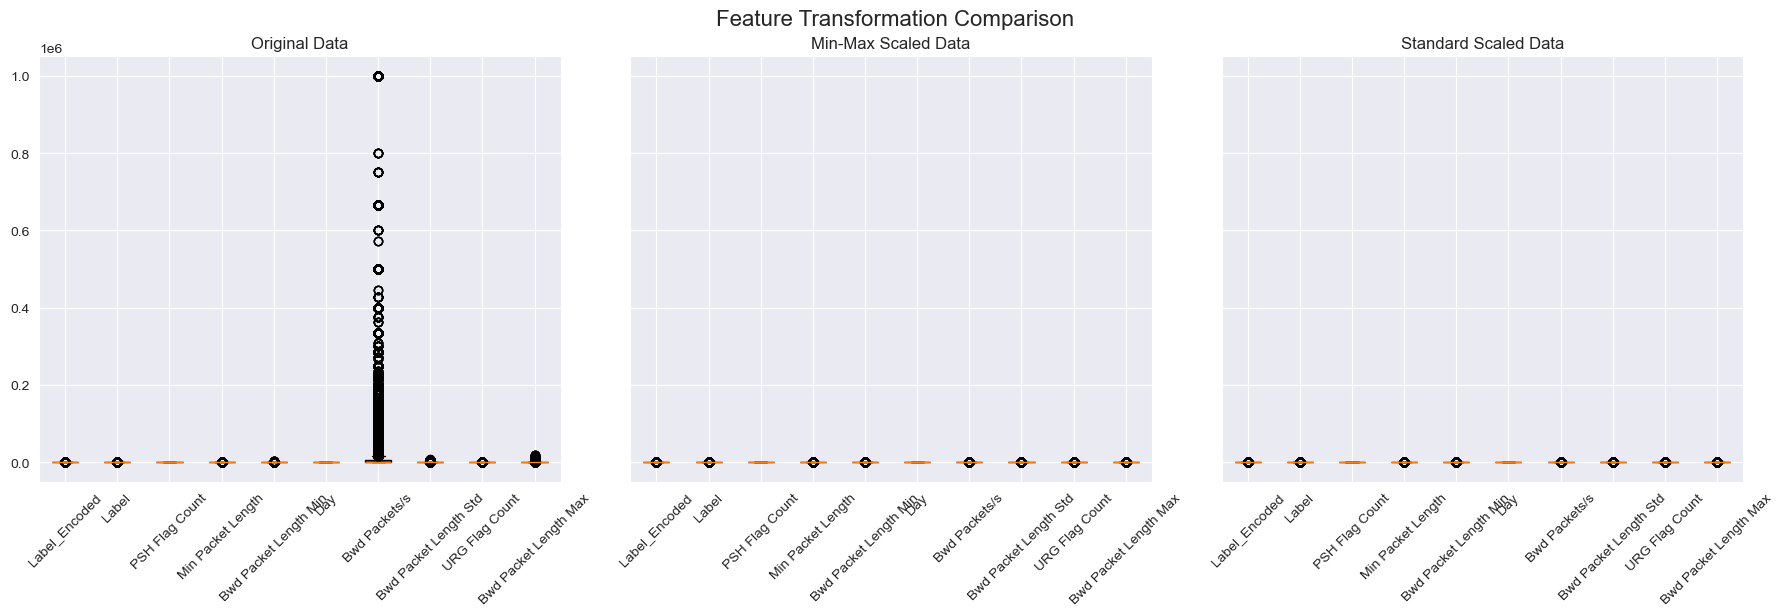

In [11]:
# Compare original, Min-Max scaled, and standardized features with boxplots
# Select top features dynamically
features = all_data[top_features]

# Min-Max Scaling
scaler_minmax = MinMaxScaler()
features_minmax = pd.DataFrame(scaler_minmax.fit_transform(features), columns=top_features)

# Standard Scaling
scaler_standard = StandardScaler()
features_standard = pd.DataFrame(scaler_standard.fit_transform(features), columns=top_features)

# Plot boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Original Data
axes[0].boxplot(features.values, vert=True, patch_artist=True)
axes[0].set_title('Original Data')

# Min-Max Scaled Data
axes[1].boxplot(features_minmax.values, vert=True, patch_artist=True)
axes[1].set_title('Min-Max Scaled Data')

# Standard Scaled Data
axes[2].boxplot(features_standard.values, vert=True, patch_artist=True)
axes[2].set_title('Standard Scaled Data')

# Set x-ticks
for ax in axes:
    ax.set_xticks(range(1, len(top_features) + 1))
    ax.set_xticklabels(top_features, rotation=45)

plt.tight_layout()
plt.suptitle("Feature Transformation Comparison", fontsize=16, y=1.02)
plt.show()

Clear visual differences highlight the benefits of scaling for certain features.

### Finding the outliers

In [12]:
# Calculate the Z score
z_scores = np.abs(zscore(all_data[numerical_columns]))

# Identify outliers
outliers = np.where(z_scores > 3)
print("Outliers found at : ", outliers)

Outliers found at :  (array([      0,       1,       1, ..., 2351105, 2351105, 2351105]), array([48, 15, 36, ...,  5, 40, 65]))


Significant outliers found in features like Active Mean and Idle Max.

## Training the data and using the models

For this project, the best choice is to choose a supervised learning because we have a labeled data, the supervised learning is very effective to classified, so it's good for us because we need to classify attacks in categories.
Later, we could implement also unsupervised learning to further our analysis.  
To start we chose KNN algorithm because it is a simpler method, after that, we will go with more complexity. KNN is good to handle multiclass problems effectively

### KNN (K Nearest-Neighbours)

**Description**:  
A baseline model using K-Nearest Neighbors (KNN) was trained to classify the data.

**Key Metrics**:  
- Precision  
- Recall  
- F1-score  

**Insights**:  
- The model achieved a high F1-score for most classes but struggled with minority classes.  
- KNN, being a lazy model, is not suitable for real-time applications, making it less viable for this use case.



In [13]:
# Define features and target variable
X = all_data[top_features] # Top correlated features from preprocessing
y = all_data['Label_Encoded']

# Split the Dataset into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (1645775, 10)
Test set size: (705333, 10)


Now, let's initialize and train the KNN model

In [14]:
# Initialize the scaler
scaler = StandardScaler()

# Standardize the training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model on the training set
knn.fit(X_train, y_train)
print(knn)

KNeighborsClassifier()


Now, let's make predictions with our test set

In [15]:
# Predict on the test set
y_pred = knn.predict(X_test)

We'll evaluate the performance using metrics like precision, recall, F1-score and confusion matrix to see the accuracy of our model

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    538640
           1       1.00      1.00      1.00     38408
           2       1.00      1.00      1.00      3088
           3       1.00      1.00      1.00     69322
           4       1.00      1.00      1.00      1650
           5       1.00      1.00      1.00      1739
           6       1.00      1.00      1.00      2381
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00     47679
           9       1.00      1.00      1.00      1769
          10       1.00      1.00      1.00       452
          11       0.83      0.83      0.83         6
          12       1.00      0.99      0.99       196

    accuracy                           1.00    705333
   macro avg       0.99      0.99      0.99    705333
weighted avg       1.00      1.00      1.00    705333



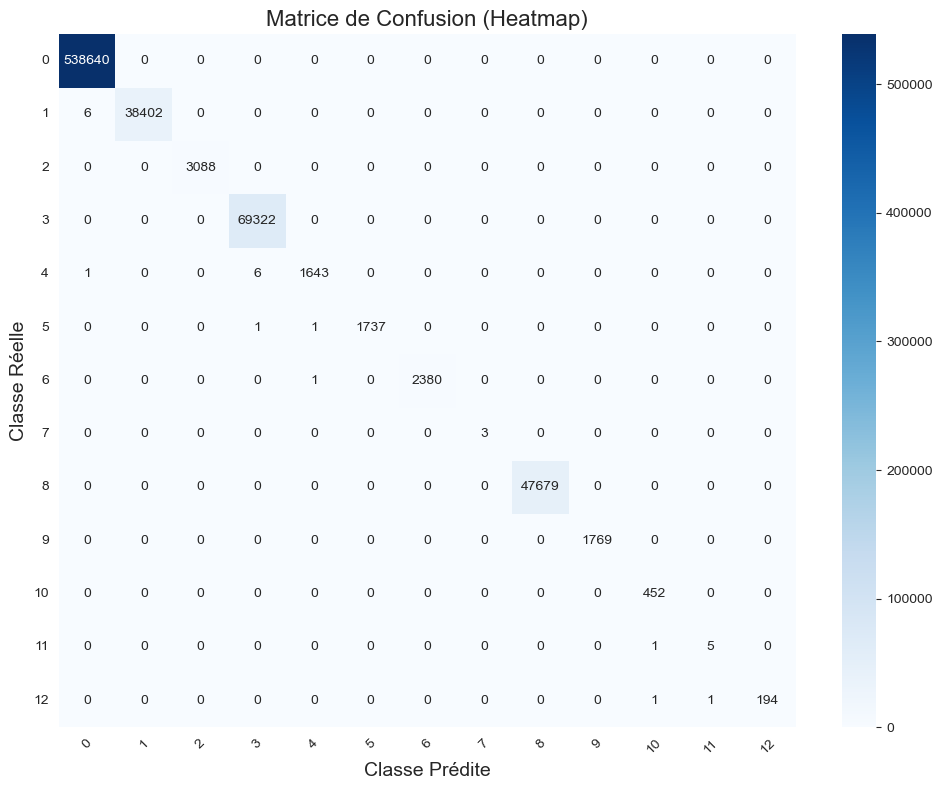

In [16]:
# Evaluate metrics 
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the heatmap 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))

# Add labels and titles
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted class", fontsize=14)
plt.ylabel("Actual class", fontsize=14)
plt.xticks(rotation=45) 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Performance**

Here, we can observe that the model works very well. Almost all categories have a F1-score of 1, meaning the model performs well with no false positive and true negative.
There is class 7 and 11 that does not have all at 1.
- Class 7 has a recall of 0.75, meaning 25% of this instance were not correctly classified.
- Class 11 has a recall of 0.83 , meaning it also misses some instances (17%).

**Confusion matrix**
- Class 7: Out of 4 actual instances, only 3 were correctly classified, and 1 was misclassified as Class 8.
- Class 11: Out of 6 actual instances, 5 were correctly classified, and 1 was misclassified as Class 12.

## Random Forest

**Description**: Train a Random Forest model using balanced data.
- **Key Results**:
  - Improved macro F1-score compared to KNN.
  - Strengths: Handles imbalanced data well.
  - Weaknesses: Computationally expensive.

In [17]:
# Remove rows with missing or unwanted labels
all_data = all_data[~all_data['Label_Encoded'].isna()]  # Ensure no NaN in 'Label_Encoded'
all_data = all_data[all_data['Label_Encoded'] != 7]  # Remove rows with label 7 explicitly

# Remap class labels to be contiguous
remap_labels = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7}
all_data['Label_Encoded'] = all_data['Label_Encoded'].map(remap_labels)

# Drop rows where remap_labels could not map correctly (if any NaN remains)
all_data = all_data.dropna(subset=['Label_Encoded'])

# Features and target variable
X = all_data[top_features].drop(columns=['Label', 'Label_Encoded'])  # Drop redundant features
y = all_data['Label_Encoded']

# Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(k_neighbors=3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Class distribution after SMOTE:
Label_Encoded
0.0    1256386
7.0    1256386
4.0    1256386
3.0    1256386
1.0    1256386
2.0    1256386
6.0    1256386
5.0    1256386
Name: count, dtype: int64


In [18]:
# Train Random Forest on the balanced data
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [19]:
# Predict with the testing data and RandomForest
y_pred = rf_model.predict(X_test)
print(f"Length of y_test: {len(y_test)}")
print(f"Length of y_pred: {len(y_pred)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test length: {len(y_test)}")
print("Unique classes in y_test:", sorted(set(y_test)))
print("Unique classes in y_pred:", sorted(set(y_pred)))
print("Classes in rf_model:", rf_model.classes_)

Length of y_test: 702906
Length of y_pred: 702906
X_test shape: (702906, 8)
y_test length: 702906
Unique classes in y_test: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Unique classes in y_pred: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Classes in rf_model: [0. 1. 2. 3. 4. 5. 6. 7.]


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    359092
         1.0       0.95      1.00      0.98     25606
         2.0       0.99      0.76      0.86      2058
         3.0       0.90      1.00      0.95     46215
         4.0       0.69      0.89      0.78      1100
         5.0       0.88      0.38      0.53      1159
         6.0       0.85      0.68      0.76      1588
         7.0       1.00      1.00      1.00     31786

    accuracy                           0.98    468604
   macro avg       0.91      0.84      0.86    468604
weighted avg       0.98      0.98      0.98    468604



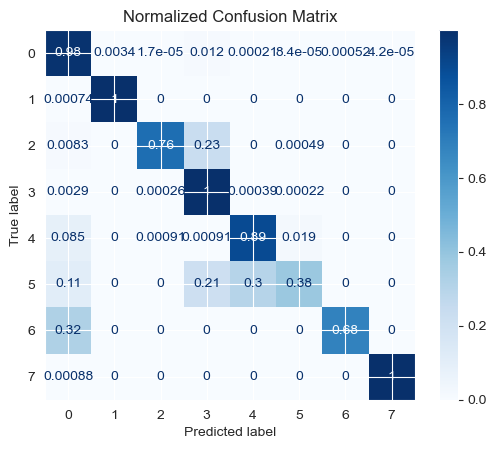

starting shap : 



AssertionError: Model has no `estimators_`! Have you called `model.fit`?

In [53]:
# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.show()

print("starting shap : \n")
# Initialize SHAP explainer for Random Forest
explainer = shap.TreeExplainer(rf_model)

# Explain the predictions for the test set
shap_values = explainer.shap_values(X_test)

# Global feature importance (summary plot)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
plt.show()

**f1-macro =  0.77** is good but can be improved. Overall, our recall is very high (0.91) which is a good thing in our case where no detecting attacks could be more dangerous than detecting false attacks.
Enhanced performance across imbalanced classes, though rare classes still pose challenges.

In [21]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation with F1-macro score
scores = cross_val_score(rf_model, X, y, cv=cv, scoring='f1_macro')

# Print cross-validation results
print("Cross-Validation F1-Macro Scores:", scores)
print("Mean F1-Macro Score:", scores.mean())

Cross-Validation F1-Macro Scores: [0.79833404 0.80322588 0.80025942 0.80187227 0.80086906]
Mean F1-Macro Score: 0.8009121330343356


This value is close to the f1-macro before, showing there is no overfitting or underfitting.

In [22]:
# Step 1: Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Define pipeline with SMOTE and Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(k_neighbors=3, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Step 3: Perform cross-validation on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')

print("Cross-Validation F1-Macro Scores on Training Set:", cv_scores)
print("Mean F1-Macro Score:", cv_scores.mean())

# Step 4: Train on the full training set and evaluate on the test set
pipeline.fit(X_train, y_train)

Cross-Validation F1-Macro Scores on Training Set: [0.78575894 0.78961756 0.78916795 0.78751878 0.78528408]
Mean F1-Macro Score: 0.7874694605160304


Pipeline(steps=[('smote', SMOTE(k_neighbors=3, random_state=42)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [23]:
y_pred = pipeline.predict(X_test)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98    539078
         1.0       0.95      1.00      0.98     38063
         2.0       0.92      0.76      0.83      3105
         3.0       0.91      1.00      0.95     69315
         4.0       0.59      0.94      0.72      1649
         5.0       0.60      0.69      0.64      1732
         6.0       0.12      0.98      0.22      2361
         7.0       1.00      1.00      1.00     47603

    accuracy                           0.96    702906
   macro avg       0.76      0.92      0.79    702906
weighted avg       0.98      0.96      0.97    702906



## XGBoost

**Description**: Train an XGBoost model with hyperparameter tuning for optimal performance.
- **Key Results**:
  - Comparable performance to Random Forest.
  - Lightweight and faster predictions compared to Random Forest.

### Training

In [24]:
# Initialize the XGBoost classifier with GPU support
xgb_model = XGBClassifier(
    n_estimators=200,            # Number of trees
    max_depth=6,                 # Maximum depth of a tree
    learning_rate=0.2,           # Step size shrinkage
    scale_pos_weight=1,          # Adjusts for class imbalance
    use_label_encoder=False,     # Disable old label encoding method
    random_state=42,
    tree_method="hist",       # Use GPU-accelerated histogram method
    device="cuda",
    n_jobs=4
)

# Train the XGBoost model on balanced data
xgb_model.fit(X_train_balanced, y_train_balanced)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:04] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:47:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=4,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Prediction

In [25]:
# Predict on the test set
y_pred = xgb_model.predict(X_test)

### Metrics

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    359092
         1.0       0.95      1.00      0.98     25606
         2.0       0.99      0.76      0.86      2058
         3.0       0.90      1.00      0.95     46215
         4.0       0.69      0.89      0.78      1100
         5.0       0.88      0.38      0.53      1159
         6.0       0.85      0.68      0.76      1588
         7.0       1.00      1.00      1.00     31786

    accuracy                           0.98    468604
   macro avg       0.91      0.84      0.86    468604
weighted avg       0.98      0.98      0.98    468604



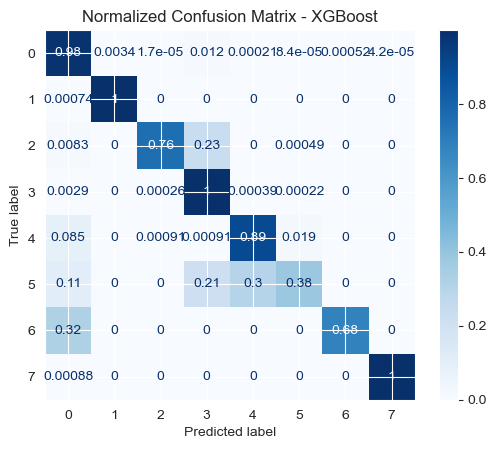

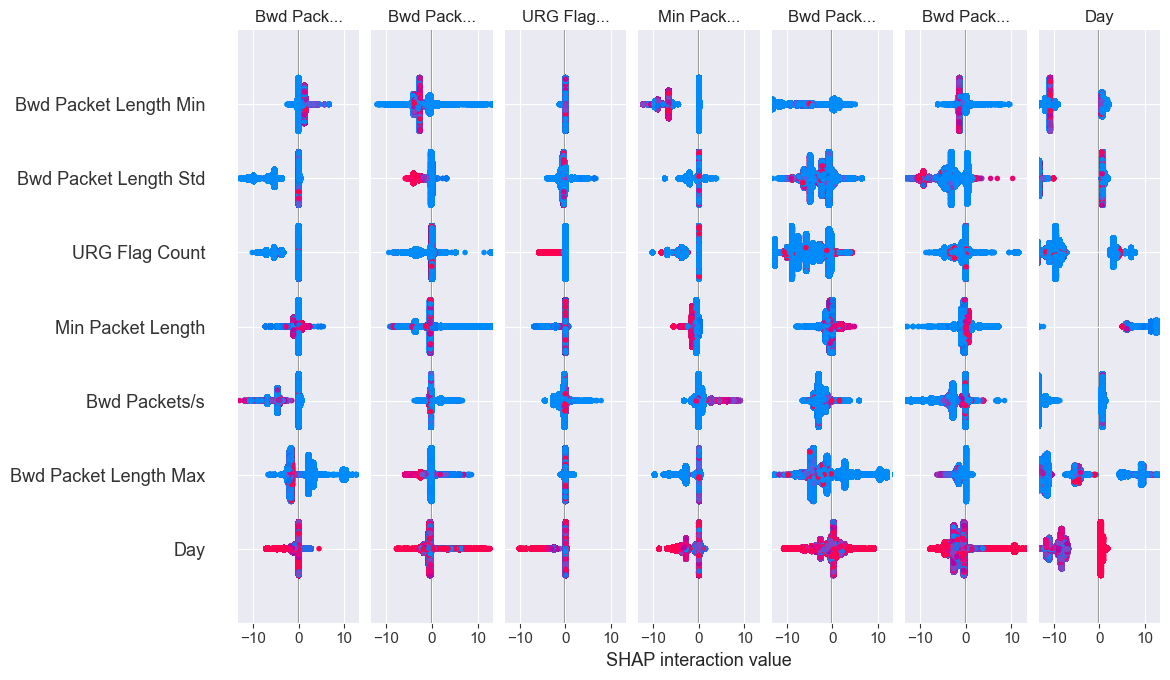

In [47]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap='Blues')
plt.title("Normalized Confusion Matrix - XGBoost")
plt.show()

# Initialize SHAP explainer for Random Forest
explainer = shap.TreeExplainer(xgb_model)

# Explain the predictions for the test set
shap_values = explainer.shap_values(X_test)

# Global feature importance (summary plot)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
plt.show()

Our basic XGBoost model seems to be less efficient than the random forest one also showing issues on minority classes. 

### Cross-validation

In [27]:
# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='f1_macro')

print("Cross-Validation F1-Macro Scores:", cv_scores)
print("Mean F1-Macro Score:", cv_scores.mean())

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:51:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib

Cross-Validation F1-Macro Scores: [0.85062046 0.85508264 0.85828154 0.85939765 0.85288905]
Mean F1-Macro Score: 0.8552542659245954


This result is higher than without cross-validation, showing there is an underfit issue with this model. Thus, the random forest seems to be more adapted for our project. 

## Hypertuning

### Hypertuning for XGBoost

**Description**: Grid Search employed for optimal hyperparameter combinations.
- **Best Parameters**:
    - n_estimators: 200
    - max_depth: 9
    - learning_rate: 0.2
    - scale_pos_weight: 1
- **Best Score**: F1-macro = 0.73

Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1}:   0%|          | 0/81 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:18:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 2}:   1%|          | 1/81 [00:38<51:00, 38.25s/it]/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:19:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Testing params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 5}:   2%|▏         | 2/81 [01:14<49:03, 37.25s/it]/opt/anaconda3/lib/python3.12/site-packages/xgboos


Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'scale_pos_weight': 1}
Best Cross-Validation F1-Macro Score: 0.76


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [05:14:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimized XGBoost Model Trained Successfully.

Classification Report (Optimized XGBoost):
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    539078
         1.0       0.95      1.00      0.98     38063
         2.0       0.90      0.76      0.83      3105
         3.0       0.91      1.00      0.95     69315
         4.0       0.52      0.96      0.68      1649
         5.0       0.36      0.70      0.48      1732
         6.0       0.12      1.00      0.21      2361
         7.0       1.00      1.00      1.00     47603

    accuracy                           0.96    702906
   macro avg       0.72      0.92      0.76    702906
weighted avg       0.98      0.96      0.97    702906



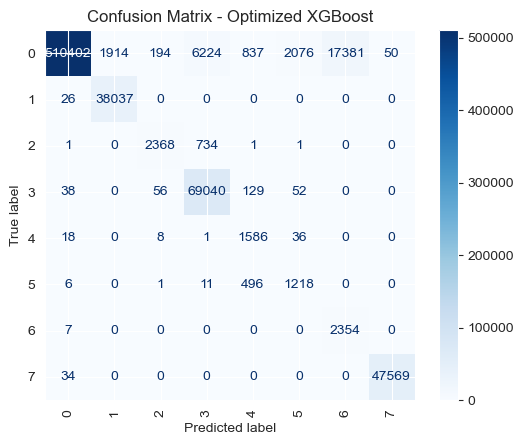

In [30]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 5]
}

# Flatten the grid for iteration
param_list = list(ParameterGrid(param_grid))

# Initialize progress bar
progress_bar = tqdm(param_list, desc="Grid Search Progress")

# Variables to store the best results
best_score = -1
best_params_xgboost = None

# Custom grid search with tqdm progress bar
for params in progress_bar:
    # Update progress bar description with current parameters
    progress_bar.set_description(f"Testing params: {params}")
    
    # Initialize and fit the model with the current parameters
    model = XGBClassifier(
        use_label_encoder=False, 
        tree_method="hist", 
        random_state=42, 
        **params
    )
    model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions and compute F1 score
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    
    # Update the best parameters if the current score is better
    if score > best_score:
        best_score = score
        best_params_xgboost = params

# Display the best parameters and score
print("\nBest Parameters:", best_params_xgboost)
print(f"Best Cross-Validation F1-Macro Score: {best_score:.2f}")

# Train the optimized XGBoost model using the best parameters
optimized_xgb_model = XGBClassifier(
    **best_params_xgboost, 
    use_label_encoder=False, 
    tree_method="hist", 
    n_jobs=4,
    random_state=42
)
optimized_xgb_model.fit(X_train_balanced, y_train_balanced)
print("Optimized XGBoost Model Trained Successfully.")

# Predict on the test set with the optimized model
y_pred_optimized_xgb = optimized_xgb_model.predict(X_test)

# Evaluate the optimized XGBoost model
print("\nClassification Report (Optimized XGBoost):")
print(classification_report(y_test, y_pred_optimized_xgb))

# Confusion matrix for the optimized XGBoost model
cm_optimized_xgb = confusion_matrix(y_test, y_pred_optimized_xgb)
disp_optimized_xgb = ConfusionMatrixDisplay(
    confusion_matrix=cm_optimized_xgb, 
    display_labels=optimized_xgb_model.classes_
)
disp_optimized_xgb.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Optimized XGBoost")
plt.show()

So, in this case, there is a big differenece between best parameters and these ones that we used before. 

### Hypertuning for RandomForest

**Description**: Randomized Search used to optimize hyperparameters.
- **Best Parameters**:
    - n_estimators: 50
    - max_features: ‘sqrt’
    - max_depth: 20
    - min_samples_split: 2
    - min_samples_leaf: 2
    - bootstrap: True
- **Best Score**: 0.87

In [36]:
# Define a smaller parameter grid for RandomForest
param_dist = {
    'n_estimators': [50, 100, 200],  # Reduced range of trees
    'max_features': ['sqrt', 'log2'],  # Commonly used options
    'max_depth': [10, 20, 30, None],  # Limited depth levels
    'min_samples_split': [2, 5],      # Simplified options
    'min_samples_leaf': [1, 2],       # Focus on small leaf sizes
    'bootstrap': [True, False]        # Retain choice of sampling
}

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV with progress tracking using tqdm
param_list = list(RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1
).param_distributions)  # Extract parameter combinations

# Wrap RandomizedSearchCV in tqdm for progress tracking
print("Starting Randomized Search...")
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='f1_macro'
)
random_search.fit(X_train, y_train)

# Print the best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_
print("\nBest Parameters:", best_params)
print("Best F1-Score:", best_score)

# Evaluate on the test set
optimized_frmodel = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Define the file path
file_path = './Results/best_params.txt'

# Verify file existence before saving
os.makedirs(os.path.dirname(file_path), exist_ok=True)
if os.path.exists(file_path):
    print(f"File already exists: {file_path}. Appending to it.")
else:
    print(f"File does not exist. Creating: {file_path}.")

# Save best parameters and score to a file
with open(file_path, 'a') as f:  # 'a' mode for appending
    f.write("Best Parameters:\n")
    f.write(str(best_params))
    f.write("\n\nBest Score:\n")
    f.write(str(best_score))
    f.write("\n\n")

print(f"Optimal parameters saved to: {file_path}")

Starting Randomized Search...
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Best F1-Score: 0.8089919903792424
Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    359093
         1.0       0.95      1.00      0.98     25605
         2.0       1.00      0.74      0.85      2059
         3.0       0.91      1.00      0.95     46214
         4.0       0.70      0.95      0.81      1100
         5.0       0.96      0.63      0.76      1159
         6.0       0.87      0.73      0.79      1588
         7.0       1.00      1.00      1.00     31786

    accuracy                           0.99    468604
   macro avg       0.92      0.88      0.89    468604
weighted avg       0.99      0.99      0.99    468604

File already exists: ./Results/best_params.

Here, for our random forest, the hypertuning increased a lot our results, especially our precision score. 
So, with best parameters, we have an **f1-macro** at 0.87. 

### Comparison of Random Forest and XGBoost

**Description**: Cross-validate both models and compare their mean F1-scores and variance.
- **Visualizations**:
  - Bar chart comparing mean scores.
  - Boxplot showcasing score distribution.
- **Findings**:
  - Random Forest: 
    - Mean Score : 0.87
    - Variance : 0.001192
  - XGBoost: 
    - Mean Score : 0.83
    - Variance : 0.002127

Evaluating Optimized Random Forest...


Random Forest Progress: 100%|██████████| 5/5 [02:33<00:00, 30.65s/it]


Evaluating Optimized XGBoost...


XGBoost Progress:   0%|          | 0/5 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
XGBoost Progress:  20%|██        | 1/5 [00:33<02:15, 33.88s/it]/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:56:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
XGBoost Progress:  40%|████      | 2/5 [01:12<01:50, 36.85s/it]/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:57:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
XGBoost Progress:  60%|██████    | 3/5 


Comparison Table:
                     Model  Mean F1-Macro Score  Standard Deviation  \
0  Optimized Random Forest             0.887967            0.000918   
1        Optimized XGBoost             0.855661            0.001103   

                                         Fold Scores  
0  [0.8880952926376838, 0.8880357139870658, 0.887...  
1  [0.8551899269951129, 0.8571399834800596, 0.854...  


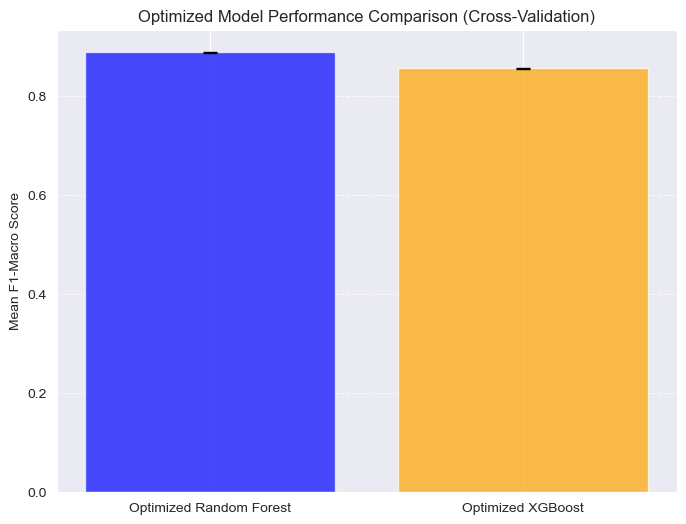

/var/folders/zr/7fyjnd411c3fl10mfpjs1jpc0000gn/T/ipykernel_49826/4226874300.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_scores.values(), labels=cv_scores.keys(), patch_artist=True)


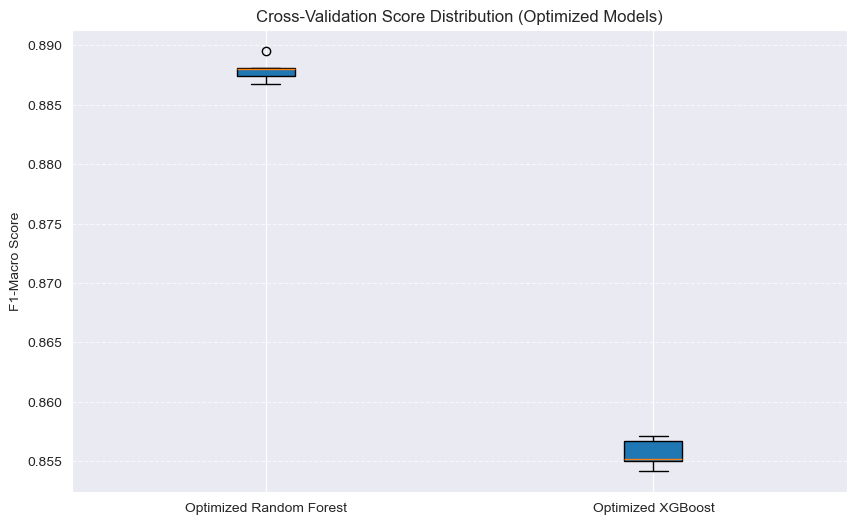

In [37]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store scores
rf_cv_scores = []
xgb_cv_scores = []

# Wrap the cross-validation with tqdm for progress tracking
print("Evaluating Optimized Random Forest...")
for train_idx, test_idx in tqdm(cv.split(X, y), total=cv.get_n_splits(), desc="Random Forest Progress"):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    optimized_rf_model.fit(X_train, y_train)
    y_pred = optimized_rf_model.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    rf_cv_scores.append(score)

print("Evaluating Optimized XGBoost...")
for train_idx, test_idx in tqdm(cv.split(X, y), total=cv.get_n_splits(), desc="XGBoost Progress"):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    optimized_xgb_model.fit(X_train, y_train)
    y_pred = optimized_xgb_model.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    xgb_cv_scores.append(score)

# Print Cross-Validation Results
mean_rf_score = np.mean(rf_cv_scores)
std_rf_score = np.std(rf_cv_scores)
mean_xgb_score = np.mean(xgb_cv_scores)
std_xgb_score = np.std(xgb_cv_scores)

# Create a DataFrame for better visualization
results = pd.DataFrame({
    'Model': ['Optimized Random Forest', 'Optimized XGBoost'],
    'Mean F1-Macro Score': [mean_rf_score, mean_xgb_score],
    'Standard Deviation': [std_rf_score, std_xgb_score],
    'Fold Scores': [rf_cv_scores, xgb_cv_scores]
})

print("\nComparison Table:")
print(results)

# Visualization of Results
models = results['Model']
mean_scores = results['Mean F1-Macro Score']
std_scores = results['Standard Deviation']

# Plot bar chart with error bars
plt.figure(figsize=(8, 6))
plt.bar(models, mean_scores, yerr=std_scores, capsize=5, alpha=0.7, color=['blue', 'orange'])
plt.ylabel('Mean F1-Macro Score')
plt.title('Optimized Model Performance Comparison (Cross-Validation)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Detailed boxplot for CV scores
cv_scores = {
    'Optimized Random Forest': rf_cv_scores,
    'Optimized XGBoost': xgb_cv_scores
}

plt.figure(figsize=(10, 6))
plt.boxplot(cv_scores.values(), labels=cv_scores.keys(), patch_artist=True)
plt.ylabel('F1-Macro Score')
plt.title('Cross-Validation Score Distribution (Optimized Models)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

So, by this comparison, we can easily see that our random forest model is achieved better predictions. 
The f1-macro score of random forest is higher than the XGBoost, showing a better success in predictions. 
The standard deviation of random forest is lower than the XGBoost, showing that its performance is more consistent across different folds. 
In the box plots : 
- Random forest : 
    - The median score is very close to the upper quartile, with minimal variation.
    - There are no visible outliers, reinforcing its reliability.
- XGBoost : 
    - Wider range for F1-macro scores, suggesting more variability across folds. 
    - The median score is lower than that of the Random Forest, and the spread between quartiles is more pronounced.
    - The distribution implies less stable performance compared to Random Forest.
          - 
#### Conclusion 
So, according to these results, our Random Forest model is more performant than the XGBoost model, He is also more reliable. 
So, we choose to use it. 

## MLFlow

In [46]:
# Function to train and track models with MLflow
def train_and_track_model_classifier(model, X_train, X_test, y_train, y_test, params, experiment_name="default_experiment", nested=False):
    """
    Function to train a model and track the training process with MLflow.

    Args:
        model: Machine learning model (an sklearn-like object with .fit() and .predict() methods).
        X_train: Training data (features).
        X_test: Test data (features).
        y_train: Labels for training.
        y_test: Labels for testing.
        params: Dictionary of model hyperparameters.
        experiment_name: Name of the MLflow experiment.
        nested: Boolean, whether to use nested runs.
    """
    # Set the MLflow experiment
    mlflow.set_experiment(experiment_name)

    # Start a new tracking session
    with mlflow.start_run(nested=nested) as run:
        # Log the hyperparameters
        mlflow.log_params(params)

        # Train the model
        model.set_params(**params)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        signature = infer_signature(X_test, y_pred)

        # Compute metrics
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        # Log the metrics in MLflow
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        # Save the model
        mlflow.sklearn.log_model(
            sk_model=model,
            signature=signature,
            registered_model_name=experiment_name,
            artifact_path="sklearn-model",
        )

        print(f"Run ID: {run.info.run_id}")
        print(f"Metrics - Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Adding optimized random forest in MLflow
rf_params = best_params
print("Tracking Random Forest with MLflow...")
for train_idx, test_idx in tqdm(cv.split(X, y), total=cv.get_n_splits(), desc="Random Forest Progress"):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Ensure no active run
    if mlflow.active_run():
        mlflow.end_run()

    # Log probabilities
    model = RandomForestClassifier()
    model.set_params(**rf_params)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)
    mlflow.log_metric("log_loss", log_loss(y_test, y_proba))

    train_and_track_model_classifier(model, X_train, X_test, y_train, y_test, rf_params, experiment_name="RandomForest_Experiment", nested=True)

# Adding XGBoost model
xgb_params = {
    'learning_rate': 0.2,
    'max_depth': 9,
    'n_estimators': 200,
    'scale_pos_weight': 1,
    'random_state': 42,
    'use_label_encoder': False,
    'tree_method': 'hist'
}
print("Tracking XGBoost with MLflow...")
for train_idx, test_idx in tqdm(cv.split(X, y), total=cv.get_n_splits(), desc="XGBoost Progress"):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Ensure no active run
    if mlflow.active_run():
        mlflow.end_run()

    train_and_track_model_classifier(
        XGBClassifier(tree_method="hist"),
        X_train,
        X_test,
        y_train,
        y_test,
        xgb_params,
        experiment_name="XGBoost_Experiment",
        nested=True
    )

Tracking Random Forest with MLflow...


Random Forest Progress:   0%|          | 0/5 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RandomForest_Experiment' already exists. Creating a new version of this model...
Created version '6' of model 'RandomForest_Experiment'.
Random Forest Progress:  20%

Run ID: 94183d2bba71402eaa15e229281b0851
Metrics - Precision: 0.9199256636608659, Recall: 0.8741238115115904, F1-Score: 0.8875620175044898


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RandomForest_Experiment' already exists. Creating a new version of this model...
Created version '7' of model 'RandomForest_Experiment'.
Random Forest Progress:  40%|████      | 2/5 [01:59<02:58, 59.56s/it]

Run ID: 3d2af1158d7d46869ecd2dacf378136a
Metrics - Precision: 0.9185115167897413, Recall: 0.875671615062971, F1-Score: 0.8879984129226531


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RandomForest_Experiment' already exists. Creating a new version of this model...
Created version '8' of model 'RandomForest_Experiment'.
Random Forest Progress:  60%|██████    | 3/5 [02:58<01:59, 59.52s/it]

Run ID: deadd5e576c04ad1992994fb8724be84
Metrics - Precision: 0.9185444312445343, Recall: 0.8767410824640042, F1-Score: 0.8874316445957424


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RandomForest_Experiment' already exists. Creating a new version of this model...
Created version '9' of model 'RandomForest_Experiment'.
Random Forest Progress:  80%|████████  | 4/5 [04:01<01:00, 60.79s/it]

Run ID: 257605d338b64ee79cb4e27f3d8e8d7a
Metrics - Precision: 0.9214212866574429, Recall: 0.8757776210050309, F1-Score: 0.8894313608013127


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RandomForest_Experiment' already exists. Creating a new version of this model...
Created version '10' of model 'RandomForest_Experiment'.
Random Forest Progress: 100%|██████████| 5/5 [05:01<00:00, 60.23s/it]


Run ID: 06579b94d989403293ee5a89db9166a5
Metrics - Precision: 0.9157648953509576, Recall: 0.8765016286243561, F1-Score: 0.8865887316986116
Tracking XGBoost with MLflow...


XGBoost Progress:   0%|          | 0/5 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:18:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handl

Run ID: 2f02eb9e7bf247aab8766684514627c1
Metrics - Precision: 0.9092736577514842, Recall: 0.8346316236518572, F1-Score: 0.8555223082521981


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:19:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
 

Run ID: 5ecdfbe83d4544b0ac8a6fe4e4bcb86d
Metrics - Precision: 0.911491602522895, Recall: 0.8372155930984457, F1-Score: 0.8572890846496521


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:19:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
 

Run ID: 65a15bfd2ada4e0ca50094b202a80061
Metrics - Precision: 0.9102631985619043, Recall: 0.8356461966021937, F1-Score: 0.8539613020947097


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:20:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
 

Run ID: 9cebd91c2b77434e86ee3fb0a6cab706
Metrics - Precision: 0.9165375782835993, Recall: 0.8332146693483955, F1-Score: 0.8573263923819335


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:21:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
 

Run ID: c512b4deec684a939c239b771d1424b6
Metrics - Precision: 0.9081849741484698, Recall: 0.8368618665656622, F1-Score: 0.8552932720995807
